In [1]:
import datetime
import sys, os

import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.transform

In [ ]:
#!ls -ls /kaggle/input/protein-work-data-mm

In [ ]:
#
# 2018-12-03 Adding
#   aug work in BobaDataGenerator
#   common parameters in top 
#
# 2018-12-07 Adding
#   aug work by imgaug packet
#   verify parameters
#   debug mode (limit 5000 records)
#   load model datas from extenal model
#   parameters for cycling set of learning rate (lr)
#
#
#
######################################3

In [2]:
# Training parameters

epochs        =   40                 ####### <-------- Epochs number
initial_epoch =   1                 ####### >0 go to post-train for old train file

# lr - learning rate (cyclic from scb0 to scbL for scbE=epochs start with 0)

scb0          =   0.001     #### lr decreasing from scb0 to scbL
scbL          =   1e-7

scbE          =  60 #epochs+5  #### lr decreasing to scbL for scbE epochs
scbS          =  0

# Batch size
#
#  OOM - Ошибка связанная с нехваткой памяти на плате. Обычно начинают уменьшать batch_size 16, 8, 4
#
batch_size    =   1                 ####### <----------------------------------- batch size - minimum
batch_size    =   4                 ####### <----------------------------------- batch size
batch_size    =   8                 ####### <----------------------------------- batch size
batch_size    =  16                 ####### <----------------------------------- batch size


# Input size
shape_out     = (256+256,256+256,4) ####### <----------------------------------- maximum  set
shape_out     = (256+128,256+128,4) ####### <----------------------------------- interest set
#shape_out     = (256+64, 256+64, 4) ####### <----------------------------------- minimum  set
#shape_out     = (256,256,4)         ####### <----------------------------------- now's  set

#shape_out     = (128,128,4)         ####### <----------------------------------- debug's  set
#batch_size    =  128-16

# Model parameters

okeyRS        =  False  ####### <----------------------------------- model with Res-blocks

levels        =  [32,64,128,256,512,1024] ####### <----------------------------------- interest levels (maximum?)
levels        =  [32,64,128,256,512]      ####### <----------------------------------- common levels
#levels        =  [32,64,128,256]          ####### <----------------------------------- minimum levels

okeySE        =  False  ####### <----------------------------------- model with SE-blocks
okeyDebug     =  False # 5000

In [3]:
#
# Common directories
#

dirData   = '../input' # '../Data'
dataTrain = os.path.join(dirData,'train')
dataTest  = os.path.join(dirData,'test')
dirTrain  = dataTrain
dirTest   = dataTest

dataSave  = '../working' #'../Work/V01'
dirSave   = dataSave
dirLoad   = dirSave

#dirPython = '../Python'
dirModels    = '../working'
#dirModelLoad = '/kaggle/input/protein-work-data'
dirModelLoad = '../input/protein-work-data-mm1'
#dirResul  = '../Result'
#dirLogs   = '../Logs'

In [4]:
assert os.path.exists(dirData),  'not found directory dirData'
assert os.path.exists(dirTrain), 'not found directory dirTrain'
assert os.path.exists(dirTest),  'not found directory dirTest'

assert os.path.exists(dirSave), 'not found directory dirSave'
assert os.path.exists(dirLoad), 'not found directory dirLoad'

assert os.path.exists(dirModels),    'not found directory dirModels'
assert os.path.exists(dirModelLoad), 'not found directory dirModelLoad'

assert epochs>initial_epoch, 'bad epochs numbers'

In [5]:
def lastFN(dirName, ends='.hdf5', within=None) :
    lf = [tt for tt in os.listdir(dirName) if tt.endswith(ends)]
    if within is not None :
        lf = [tt for tt in os.listdir(dirName) if tt.count(within)]
    if len(lf)==0 : return(None)
    tf = [os.path.getmtime(os.path.join(dirName,tt)) for tt in lf]
    #print([tt for tt in zip(tf,lf)])
    tf = lf[np.array(tf).argsort()[-1]]
    tf = os.path.join(dirName,tf)
    return(tf)

modelLast = None if initial_epoch==0 else lastFN(dirModelLoad, within='x'.join([str(temp) for temp in shape_out]))
if (initial_epoch>0) :
    assert modelLast is not None, 'not found last load model'
if modelLast is not None :
    print('initial load model for %d epoch is\n %s' % (initial_epoch+1,modelLast))

initial load model for 2 epoch is
 ../input/protein-work-data-mm1/X-GAPCVXX-384x384x4-F2-L5XXX-W-A-0-20-2018-12-08-12-55-55.hdf5


In [ ]:
# Build file's lists and feature's array

In [6]:
ftrain = os.listdir(dataTrain)
ftest  = os.listdir(dataTest)
ftrain, ftest = sorted(ftrain), sorted(ftest)

fftrain = [ftrain[ii].split('_')[0] for ii in range(0,len(ftrain),4)]
fftest  = [ftest[ii ].split('_')[0] for ii in range(0,len(ftest),4)]

len(ftrain), len(ftest), ftrain[:8], ftest[:8]
len(fftrain), len(fftest), fftrain[:8], fftest[:8]

(31072,
 11702,
 ['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
  '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
  '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
  '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
  '001838f8-bbca-11e8-b2bc-ac1f6b6435d0',
  '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0',
  '0020af02-bbba-11e8-b2ba-ac1f6b6435d0',
  '002679c2-bbb6-11e8-b2ba-ac1f6b6435d0'],
 ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
  '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
  '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
  '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
  '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0',
  '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0',
  '001765de-bacd-11e8-b2b8-ac1f6b6435d0',
  '0018641a-bac9-11e8-b2b8-ac1f6b6435d0'])

In [7]:
trainY = pd.read_csv(os.path.join(dirData,'train.csv'),index_col=0)
trainY.head(10)

,Target
Id,
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0


In [8]:
YS = trainY.values; YS[:5]
Y  = np.zeros((len(YS),28),dtype=np.float)
for ii in range(len(YS)) :
    temp = YS[ii][0].split(' ')
    #print(temp)
    for jj in temp : Y[ii,int(jj)]=1.0
    #Y[ii] = Y[ii]/Y[ii].sum()

In [9]:
Y[:5], Y.sum(axis=(-1,)).shape

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), (31072,))

/home/svyatkin/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


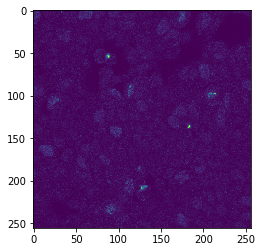

((256, 256), dtype('uint8'), 0, 247, 8145338368.0)

In [10]:
png = cv2.imread(os.path.join(dataTrain,ftrain[1]),-1)
png = skimage.transform.rescale(png,1.0/2.0)*255.0
png = png.astype(np.uint8)
plt.imshow(png); plt.show()
png.shape, png.dtype, png.min(), png.max(), int(len(ftrain))/4*256*256*4

In [ ]:
# Main input generator for train, valid and test datas

In [11]:
import imgaug as ia
from imgaug import augmenters as iaa


import keras
class BobaGenerator(keras.utils.Sequence):

    def __init__(self, dirImages, nameImages, labels, batch_size, shape_out, 
                 weightsOK=False, 
                 aug=False, augP=0.15, # list features with augmentation by augP-probability
                 debug=False,
                 printOK=False) :
        
        assert len(nameImages)==len(labels),'not equal lengths X and Y'
        self.dirImages, self.nameImages, self.y = dirImages, np.array(nameImages), labels
        self.batch_size                         = batch_size
        
        if debug and not (type(debug)==type(9000)) : debug = 9000
        
        if debug : 
            self.nameImages, self.y = self.nameImages[:debug], self.y[:debug]
        
        png            = cv2.imread(os.path.join(dirImages,nameImages[0]+'_red.png'),-1)
        self.shape_in  = png.shape
        self.shape_out = shape_out
        
        self.freq      = labels.sum(axis=0)
        self.freq[self.freq==0.0] = self.freq.max()+1.0
        self.freq      = np.divide(1.0,self.freq)
        self.freq      = np.divide(self.freq,self.freq.max())
        
        self.beforeAug = len(self.y)
        
        if aug :
            
            if printOK : 
                print('aug True : size before %d %d' %(len(self.nameImages), len(self.y)))
            
            augN, augY = [], []
            for iaug in aug :
                naug = (self.y[:,iaug]==1)
                augN.append(self.nameImages[naug])
                augY.append(self.y[naug])
            augN            = np.hstack(augN)
            self.nameImages = np.hstack([self.nameImages, augN])
            augY            = np.vstack(augY)
            self.y          = np.vstack([self.y, augY])
            
            if printOK : 
                print('aug True : size after  %d %d' %(len(self.nameImages), len(self.y)))
            
            del augN, augY
        
        
        self.nFiles    = int(len(self.nameImages)*4)
        self.nPicts    = int(len(self.y))
        self.nIters    = int(np.ceil(self.nPicts / float(self.batch_size)))
        
        self.weightsOK = weightsOK
        self.aug       = aug;
        self.augP      = augP
        
        if self.aug : self.augproc = self.__aug()
        
        if printOK :
            print('iFiles=%d iPicts=%d iBatches=%d last batch=%d'%(self.nFiles, self.nPicts, 
                                                                   self.nIters, self.nPicts%batch_size))
            #print(self.freq.shape, self.freq)
            
    def __len__(self):
        return self.nIters

    def __getitem__(self, idx):
        
        nn     = np.arange(idx*self.batch_size,
                           min(min((idx+1),self.__len__())*self.batch_size,self.nPicts))
                                                   
        nn     = np.int32(nn)
        batchX = np.zeros((len(nn),)+self.shape_out, dtype=np.uint8)
        
        batchY = self.y[nn]
        batchW = (np.multiply(batchY,self.freq).max(axis=1))*10.0
        
        for ii in nn :
            #print(ii, self.shape_out,  batchX.shape, nn)
            try : batchX[ii-nn[0]] = self.__load_image(ii, self.shape_out)
            except Exception as e :  print('except load image', ii, e.strerror)
                
        if self.aug and nn[-1]>=self.beforeAug :
            batchX[(max(self.beforeAug,nn[0])-nn[0]):]  = self.augproc.augment_images(batchX[(max(self.beforeAug,nn[0])-nn[0]):])
            batchW[(max(self.beforeAug,nn[0])-nn[0]):] *= self.beforeAug/float(self.nPicts)
            
        if not self.weightsOK : batchW[:] = 1.0
            
        return (batchX, batchY, batchW)
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __aug (self) :
        seq = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            iaa.Flipud(0.5), # horizontal flips
            iaa.OneOf([
                iaa.Crop(percent=(0, 0.1)), # random crops

                # Small gaussian blur with random sigma between 0 and 0.5.
                # But we only blur about 50% of all images.
                iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 0.5))),

                # Add gaussian noise.
                # For 50% of all images, we sample the noise once per pixel.
                # For the other 50% of all images, we sample the noise per pixel AND
                # channel. This can change the color (not only brightness) of the
                # pixels.
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                ],0.5),
            iaa.OneOf([
                iaa.Crop(percent=(0, 0.1)), # random crops

                # Strengthen or weaken the contrast in each image.
                iaa.ContrastNormalization((0.75, 1.5)),

                # Make some images brighter and some darker.
                # In 20% of all cases, we sample the multiplier once per channel,
                # which can end up changing the color of the images.
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                ],0.6),
            iaa.OneOf([
                iaa.Crop(percent=(0, 0.1)), # random crops

                # Apply affine transformations to each image.
                # Scale/zoom them, translate/move them, rotate them and shear them.
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-10, 10),
                    shear=(-3, 3)
                )],0.2)
            ], random_order=True)
        return seq 
        
    def __load_image (self, idx, shape_out) :
        train = np.zeros(self.shape_in+(4,),dtype=np.uint8)
        train[...,0] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx]+'_red.png'),-1)    # R
        train[...,1] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx]+'_green.png'),-1)  # G
        train[...,2] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx]+'_blue.png'),-1)   # B
        train[...,3] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx]+'_yellow.png'),-1) # Y
        train = cv2.resize(train, (shape_out[1],shape_out[0]))
        #print(train.shape, shape_out)
        return train
    
    def __load_image_old (self, idx, shape_out) :
        train = np.zeros(self.shape_in+(4,),dtype=np.uint8)
        train[...,0] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx*4+2]),-1) # R
        train[...,1] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx*4+1]),-1) # G
        train[...,2] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx*4+0]),-1) # B
        train[...,3] = cv2.imread(os.path.join(self.dirImages,self.nameImages[idx*4+3]),-1) # Y
        train = cv2.resize(train, (shape_out[1],shape_out[0]))
        #print(train.shape, shape_out)
        return train

/home/svyatkin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
tgt   = BobaGenerator(dirTrain, fftrain, Y, batch_size, shape_out, weightsOK=True, printOK=True, debug=okeyDebug) #9000)
train, trainY, weightX = tgt[0]
len(train), train.shape

iFiles=124288 iPicts=31072 iBatches=1942 last batch=0


(16, (16, 384, 384, 4))

In [13]:
import keras

from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D, Dense, Reshape, Flatten, AveragePooling2D
from keras.layers import RepeatVector, ZeroPadding2D, Cropping2D, multiply, average, add, subtract
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

import keras.backend as K 

In [14]:
import tensorflow as tf

In [15]:
keras.__version__

'2.1.6'

In [ ]:
# Main 2 models

In [16]:
def GAPNET_PLXX (input_shape, output_shape, dropout=False, levels=[32,64,128,256], act='relu', seOK=False) :
    
    def se_layer(x, out_dim, ratio = 4) : #4):
        '''
        SE module performs inter-channel weighting.
        '''
        squeeze = GlobalAveragePooling2D()(x)

        excitation = Dense(units=out_dim // ratio)(squeeze)
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=out_dim)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,1,out_dim))(excitation)

        scale = multiply([x,excitation])

        return scale

    ##act= 'relu' # None
    
    i  = Input(shape=input_shape, name='input'); a = i
    
    a  = BatchNormalization()(a)
    a  = Activation('relu')(a)
    
    ccc= GlobalAveragePooling2D()(a);
    
    n  = a
    
    for dim in levels[:-2] :
    
        n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n) 

        n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n)    
        n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n)


        if seOK : n = se_layer(n,dim)
        
        n  = MaxPooling2D(2)(n);  
        n  = BatchNormalization()(n)
        n  = Activation('relu')(n)

        c10= GlobalAveragePooling2D()(n);
        #c10= BatchNormalization()(c10)
        #c10= Activation('relu')(c10)
        
        ccc = Concatenate() ([ccc,c10])

        if dropout : n = Dropout(dropout)(n)
            
    
    dim= levels[-2]
    n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n)
    n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n)
    n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n)

    if seOK : n = se_layer(n,dim)
        
    n  = BatchNormalization()(n)
    n  = Activation('relu')(n)
    
    c30 = GlobalAveragePooling2D()(n);
    #c30= BatchNormalization()(c30)
    #c30= Activation('relu')(c30)
    
    n  = Concatenate()([ccc,c30])
    if dropout : n = Dropout(dropout)(n)
    
    dim= levels[-1]
    n  = Dense(dim, activation=act)(n)
    n  = BatchNormalization()(n)
    n  = Activation('relu')(n)
    
    n  = Dense(dim, activation=act)(n)
    n  = BatchNormalization()(n)
    n  = Activation('relu')(n)
    
    o  = Dense(output_shape)(n)
    o  = Activation('sigmoid')(o)
        
    return Model(inputs=i, outputs=o, name='GAPCVXX')

if 0 :

    model10 = GAPNET_PLXX((256,256,4), 28, dropout=0.2 , levels=[32,64,128,256,512], seOK=True)
    model10.summary()

In [17]:
def GAPNET_RS (input_shape, output_shape, dropout=False, act='relu', levels=[32,64,128,256], seOK=True) :
    
    def se_layer(x, out_dim, ratio = 4) : #4):
        '''
        SE module performs inter-channel weighting.
        '''
        squeeze = GlobalAveragePooling2D()(x)

        excitation = Dense(units=out_dim // ratio)(squeeze)
        excitation = Activation('relu')(excitation)
        excitation = Dense(units=out_dim)(excitation)
        excitation = Activation('sigmoid')(excitation)
        excitation = Reshape((1,1,out_dim))(excitation)

        scale = multiply([x,excitation])

        return scale

    def residual_block(blockInput, num_filters=16, seOK = True, batch_activate = False):
        x = BatchActivate(blockInput)
        x = convolution_block(x, num_filters, (3,3))
        x = convolution_block(x, num_filters, (3,3), activation=False)

        if seOK : x = se_layer(x,num_filters)

        x = Add()([x, blockInput])
        if batch_activate:
            x = BatchActivate(x)
        return x

    def BatchActivate(x):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
        x = Conv2D(filters, size, strides=strides, padding=padding, kernel_initializer='he_normal')(x)
        if activation == True:
            x = BatchActivate(x)
        return x    
    
    i  = Input(shape=input_shape, name='input'); a = i
    
    a  = BatchNormalization()(a)
    a  = Activation('relu')(a)
    
    ccc= GlobalAveragePooling2D()(a);
    
    n  = a
    
    for dim in levels[:-2] :
    
        n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n) 

        n  = residual_block(n,dim,seOK=seOK)
        n  = residual_block(n,dim,batch_activate=True,seOK=seOK);

        n  = MaxPooling2D(2)(n);  
        n  = BatchNormalization()(n)
        n  = Activation('relu')(n)

        c10= GlobalAveragePooling2D()(n);
        #c10= BatchNormalization()(c10)
        #c10= Activation('relu')(c10)
        
        ccc = Concatenate() ([ccc,c10])

        if dropout : n = Dropout(dropout)(n)
            
    dim= levels[-2]
    n  = Conv2D(dim, (3, 3), strides=1, activation=act, padding='same')(n)
    n = residual_block(n,dim,seOK=seOK)
    n = residual_block(n,dim,batch_activate=True,seOK=seOK);
    
    n  = BatchNormalization()(n)
    n  = Activation('relu')(n)
    
    c30 = GlobalAveragePooling2D()(n);
    #c30= BatchNormalization()(c30)
    #c30= Activation('relu')(c30)
    
    n  = Concatenate()([ccc,c30])
    if dropout : n = Dropout(dropout)(n)
    
    dim= levels[-1]
    n  = Dense(dim, activation=act)(n)
    n  = BatchNormalization()(n)
    n  = Activation('relu')(n)
    
    n  = Dense(dim, activation=act)(n)
    n  = BatchNormalization()(n)
    n  = Activation('relu')(n)
    
    o  = Dense(output_shape)(n)
    o  = Activation('sigmoid')(o)
        
    return Model(inputs=i, outputs=o, name='GAPRSXX')

if 0 :

    model10 = GAPNET_RS((256,256,4), 28, dropout=0.2, levels=[32,64,128,256,512])
    model10.summary()

In [ ]:
# functions for predict, model load&create. Metrics and loss functions.

In [18]:
import sys

from keras.models import load_model

#sys.path.append('../Python')
#from zooMetrics import lossZdice, diceCC
import numpy as np

def modelLoadOnly (filemodel) : # , customs={'lossZdice': lossZdice,'diceCC': diceCC}) :
    model10 = load_model(filemodel,compile=False) #,custom_objects=customs)
    return(model10)

def modelLoad (filemodel, customs={}, **kwarg) :
    model10 = load_model(filemodel,compile=True,custom_objects=customs)
    return(model10)


def modelPredict (model, XX, batch_size=18, **kwarg) :
    PP = model.predict(XX,batch_size=batch_size)
    return(PP)

def modelLoadAndPredict (filepath, XX, **kwarg) :
    #print ('load predict',type(XX))
    model10 = modelLoad(filepath, **kwarg)
    PP      = modelPredict(model10, XX, **kwarg)
    return(PP)



In [19]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred, threshold=0.5):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0.0, 1.0), threshold), K.floatx())
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1.0-y_true)*(1.0-y_pred), 'float'), axis=0)
    
    fp = K.sum(K.cast(y_true*(1.0-y_pred), 'float'), axis=0)
    fn = K.sum(K.cast((1.0-y_true)*y_pred, 'float'), axis=0)

    #tp = tf.where(y_true==.0, tf.ones_like(tp), tp)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    ############p, r = K.mean(p), K.mean(r)

    f1 = 2.0*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1) #tf.zeros_like(f1), f1)
    #return K.clip(f1,0.0,1.0), tp, tn, fp, fn, p, r
    return K.clip(K.mean(f1),0.0,1.0)
    #return K.mean(f1)

def f1A(y_true, y_pred, threshold=.5):
    
    #y_pred = tf.where(y_pred<(threshold*K.ones_like(y_pred)), tf.zeros_like(y_pred), tf.ones_like(y_pred))

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1.0-y_true)*(1.0-y_pred), 'float'), axis=0)
    
    fp = K.sum(K.cast(y_true*(1.0-y_pred), 'float'), axis=0)
    fn = K.sum(K.cast((1.0-y_true)*y_pred, 'float'), axis=0)

    tp = tf.where(y_true==.0, tf.ones_like(tp), tp)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    #return (f1)
    return K.mean(f1)

def f1B(y_true, y_pred, threshold=.5):
    
    #y_pred = tf.where(y_pred<(threshold*K.ones_like(y_pred)), tf.zeros_like(y_pred), tf.ones_like(y_pred))
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1.0-y_true)*(1.0-y_pred), 'float'), axis=1)
    
    fp = K.sum(K.cast(y_true*(1.0-y_pred), 'float'), axis=1)
    fn = K.sum(K.cast((1.0-y_true)*y_pred, 'float'), axis=1)

    tp = tf.where(y_true==.0, tf.ones_like(tp), tp)
    
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    f1 = 2*p*r / (p+r+K.epsilon())
    
    return f1

#def focal_loss(y_true, y_pred, gamma=2., alpha=.75):
def focal_loss(y_true, y_pred, gamma=5., alpha=.75):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred=K.clip(y_pred,eps,1.-eps)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        
        pt_1 = K.clip(pt_1,eps,1.-eps)
        pt_0 = K.clip(pt_0,eps,1.-eps)
        
        return (-K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-
                 K.mean((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0)))
    return focal_loss_fixed(y_true,y_pred)


def lossloss(y_true, y_pred, G=5., A=.75, F=8.) :
    #return(focal_loss(y_true,y_pred))
    return(K.clip(K.log(2.0-f1A(y_true,y_pred)),0.0,1.0)*F+ #5+
           focal_loss(y_true,y_pred, gamma=G, alpha=A)) ## must be best
    #return(((K.clip(K.log(2.0-f1_(y_true,y_pred)),0.0,1.0))*5+K.binary_crossentropy(y_true,y_pred)))
    #return(K.log(2.0-f1A(y_true,y_pred)))
    #return(1.0-f1B(y_true,y_pred))

print(datetime.datetime.now())

2018-12-08 13:24:14.905230


In [20]:
def createNet (shape, channel_out, **kwarg) :

    if not okeyRS : model10 = GAPNET_PLXX(shape,channel_out, dropout=0.3, levels=levels, seOK=okeySE)
    else :          model10 = GAPNET_RS  (shape,channel_out, dropout=0.3, levels=levels, seOK=okeySE)
    
    model10.compile(loss=lossloss, optimizer='Adamax', metrics=['binary_accuracy',f1])

    return(model10)

In [ ]:
# Class for using cyclic learning rate

In [21]:
import keras.callbacks as callbacks
from keras.callbacks import Callback, LearningRateScheduler

# https://github.com/titu1994/Snapshot-Ensembles

class SnapshotModelCheckpoint(Callback):
    """Callback that saves the snapshot weights of the model.
    Saves the model weights on certain epochs (which can be considered the
    snapshot of the model at that epoch).
    Should be used with the cosine annealing learning rate schedule to save
    the weight just before learning rate is sharply increased.
    # Arguments:
        nb_epochs: total number of epochs that the model will be trained for.
        nb_snapshots: number of times the weights of the model will be saved.
    """

    def __init__(self, nb_epochs, nb_snapshots): ##, fn_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()

        self.check = nb_epochs // nb_snapshots

    def on_epoch_end(self, epoch, logs={}):
        if epoch != 0 and (epoch + 1) % self.check == 0:
            pass

class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1, min_lr=5e-6, damp=False, offset=0):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        self.alpha_min  = min_lr
        self.damp       = damp
        self.offset     = offset

    def get_callbacks(self, model_prefix='Model'):
        """
        Creates a list of callbacks that can be used during training to create a
        snapshot ensemble of the model.
        Args:
            model_prefix: prefix for the filename of the weights.
        Returns: list of 3 callbacks [ModelCheckpoint, LearningRateScheduler,
                 SnapshotModelCheckpoint] which can be provided to the 'fit' function
        """
        
        callback_list = [LearningRateScheduler(schedule=self._cosine_anneal_schedule, verbose=1),]

        return callback_list

    def _cosine_anneal_schedule(self, t_):
        t = t_ + self.offset
        #if t<15 : return float(self.alpha_zero)
        if self.damp and (t % (self.T // self.M))==0 and (t>0) : 
            self.alpha_zero *= self.damp
            #self.alpha_min  *= self.damp
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        #return max(float((self.alpha_zero-self.alpha_min) / 2 * cos_out+self.alpha_min),self.alpha_min)
        return max(float(self.alpha_zero/2.0 * cos_out),self.alpha_min)
    
if 1 :
    sn_sn = SnapshotCallbackBuilder(scbE+1, 1, scb0, scbL, offset=scbS) #, damp=0.5)
    
    print('using lr from %d to %d epochs' % (initial_epoch+1, epochs))
    print([(t,sn_sn._cosine_anneal_schedule(t)) for t in range(initial_epoch+1,epochs+1)])

using lr from 2 to 40 epochs
[(2, 0.0009973499378072945), (3, 0.0009940439480455386), (4, 0.000989427842547679), (5, 0.0009835138623956602), (6, 0.0009763176904016913), (7, 0.0009678584095202469), (8, 0.0009581584522435024), (9, 0.0009472435411143978), (10, 0.0009351426205150777), (11, 0.0009218877799115928), (12, 0.0009075141687584057), (13, 0.0008920599032883552), (14, 0.0008755659654352599), (15, 0.0008580760941571966), (16, 0.0008396366694486466), (17, 0.0008202965893490875), (18, 0.0008001071402741842), (19, 0.0007791218610134325), (20, 0.0007573964007549155), (21, 0.00073498837151366), (22, 0.0007119571953549304), (23, 0.0006883639468175926), (24, 0.0006642711909554174), (25, 0.0006397428174258048), (26, 0.0006148438710658978), (27, 0.0005896403794053679), (28, 0.0005641991775732756), (29, 0.0005385877310633231), (30, 0.0005128739568274944), (31, 0.00048712604317250577), (32, 0.00046141226893667693), (33, 0.00043580082242672456), (34, 0.00041035962059463217), (35, 0.0003851561289

In [ ]:
# Build stratified folds 0..3

In [22]:
if 1 :
    orderY = (-Y.sum(axis=0)).argsort()
    classY = np.zeros((Y.shape[0]), dtype=np.uint64)
    classZ = np.packbits(Y.reshape((len(Y),4,7)).astype(bool),axis=-1).astype(np.uint64).squeeze()
    classY[:] = classZ[:,0]+classZ[:,1]*256+classZ[:,2]*256*256+classZ[:,3]*256*256*256
    #print(classZ.shape, classZ[:4], classY[:4])
    #for ii,yy in enumerate(orderY) :
    #    classY[np.logical_and(all_true,Y[:,yy])] = ii+1
        
    print(Y.sum(axis=0).astype(np.uint16))
    
    #print(Y[all_true].sum(axis=0).astype(np.uint16))
    
    from sklearn.model_selection import StratifiedKFold
    cc     = classY #[classY>0]
    folds  = []
    skf = StratifiedKFold(n_splits=4)
    for xftrain, xftest in skf.split(cc, cc):
        print("%s %s" % (len(xftrain), len(xftest)))
        folds.append([xftrain,xftest])
    folds = np.array(folds)
    print(folds.shape)
    print(folds)
    np.save(os.path.join(dirSave,'train-folds.npy'),folds)
    
else :
    folds = np.load(os.path.join(dirSave,'train-folds.npy'))
    print(datetime.datetime.now(), folds.shape)
    #ff     = np.zeros(cc.shape,dtype=np.uint8)
    #ff[fftrain] = 1
    #ff[fftest]  = 2
    #folds     = np.zeros((Y.shape[0]), dtype=np.uint8)
    #folds[all_true] = ff
    #print(folds[:50], folds[all_true].shape, ff.shape)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093
   688   537  1066    21   530   210   902  1482   172  3777   802  2965
   322  8228   328    11]
23047 8025
23231 7841
23410 7662
23528 7544
(4, 2)
[[array([  247,  1024,  1869, ..., 31069, 31070, 31071])
  array([    0,     1,     2, ..., 30586, 30785, 31004])]
 [array([    0,     1,     2, ..., 31069, 31070, 31071])
  array([  247,  1024,  1869, ..., 30692, 30731, 30800])]
 [array([    0,     1,     2, ..., 31069, 31070, 31071])
  array([ 3622,  4562,  5194, ..., 30284, 30929, 30936])]
 [array([    0,     1,     2, ..., 30929, 30936, 31004])
  array([10975, 12838, 13710, ..., 31069, 31070, 31071])]]


/home/svyatkin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


In [ ]:
# Small auxilar function

In [23]:
def ModelLayerName(model) :
    for ii,ll in enumerate(model.layers) :
        print(ii, ll.trainable, ll.name)
        
def ModelFreeze(model, nLayers, trainOK) :
    for nn in nLayers :
        model.layers[nn].trainable = trainOK
        #print(nn,model.layers[nn].name)
    print('freeze: ',len(nLayers),' layers')
        
def ModelUnFreeze(model) :
    for ll in model.layers : ll.trainable = True

In [ ]:
# Main training cycle

In [24]:
if 1 : 
    
    try    : del  xxx_train0, yyy_train0, xxx_valid0, yyy_valid0
    except : pass
    
    print(datetime.datetime.now(), ('debug mode' if okeyDebug else ''))

    verbose       =    2
    
    #################################

    metric      = 'binary_accuracy'
    metric      = 'f1'

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #for iFold in range(folds.shape[0]) :
    for iFold in [2,] :
    
        #for ic in range(4) :
        #iFold = 0
        
        if iFold<0 : continue;
            
        nntrain, nnvalid = folds[iFold]
        
        
        okeyWeights = True
        
        #aug = False,
        aug = [27,15,10,9,8]*4+[20,17,24,26]+[16,13,12,22,18]+[8,14,11]
        #aug=[6,8,9,10,11,12,13,15,16,17,18,20,22,24,26,27]
        
        tgt = BobaGenerator(dirTrain, np.array(fftrain)[nntrain], Y[nntrain], batch_size, 
                            shape_out, 
                            weightsOK=okeyWeights, 
                            aug = aug,
                            debug=okeyDebug,
                            printOK=True)
        vgt = BobaGenerator(dirTrain, np.array(fftrain)[nnvalid], Y[nnvalid], batch_size, 
                            shape_out, 
                            weightsOK=okeyWeights,
                            debug=okeyDebug,
                            printOK=True)
        
        suffix = ''
        suffix += '-L5'
        suffix += ('-SE' if okeySE else '')+('-D' if okeyDebug else 'XXX')+('-W' if okeyWeights else '')
        suffix += ('-A'  if aug    else '')
        suffix += '-%d-%d' % (initial_epoch,epochs)
        
        xxx_train0, yyy_train0,_ = tgt[0]
        
        
        
        
    
        if initial_epoch==0 :
            K.clear_session()
            model10 = createNet(xxx_train0.shape[1:],yyy_train0.shape[-1],
                                batchX=True, 
                                dim=8, depth=4, 
                                acti=None,
                                dropout=False) #0.20)
        else :
            K.clear_session()
#             fm = os.path.join(dirModelLoad,'X-GAPRSXX-256x256x4-F2-G5A75AF8-L5-SE-XXX-2018-12-01-23-39-50.hdf5');
#             fm = os.path.join(dirModelLoad,'X-GAPCVXX-384x384x4.hdf5');
            fm = modelLast
            print(fm)
            model10 = modelLoad(fm, customs={'f1':f1,'lossloss':lossloss})
            ModelUnFreeze(model10)
            
            model10.compile(loss=lossloss, optimizer='Adamax', metrics=['binary_accuracy',f1])

        pshape     = 'x'.join([str(temp) for temp in xxx_train0.shape[1:]])
        prefix     = model10.name + '-' + pshape +'-F'+str(iFold)
        
        prefix += suffix; print(prefix)

        #if 1 : continue

        filepath1  = os.path.join(dirModels,"F-"+prefix+"-val_loss-best.hdf5")
        filepath   = os.path.join(dirModels,"F-"+prefix+"-val_"+metric  + "-best.hdf5")

        checkpoint   = ModelCheckpoint(filepath,   monitor='val_'+metric,   
                                       verbose=1, save_best_only=True, mode='max')

        checkpoint1  = ModelCheckpoint(filepath1,  monitor='val_loss',   
                                       verbose=1, save_best_only=True, mode='min')
        
        scb            = SnapshotCallbackBuilder(scbE+1, 1, scb0, scbL, offset=scbS) #, damp=0.5)

        hist1  = model10.fit_generator(tgt, steps_per_epoch=len(tgt),
                                       validation_data=vgt, validation_steps=len(vgt),
                                       epochs=epochs, initial_epoch = initial_epoch,
                                       callbacks=[checkpoint, checkpoint1,] + scb.get_callbacks(),
                                       max_queue_size = 10*10, #################################
                                       verbose=verbose)

        if 1 :
            
            ModelUnFreeze(model10)
            filepath = os.path.join(dirModels,
                                    "X-"+prefix+"-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".hdf5")
            model10.save(filepath)

    print(datetime.datetime.now())

2018-12-08 13:24:29.666261 
aug True : size before 23410 23410
aug True : size after  29012 29012
iFiles=116048 iPicts=29012 iBatches=1814 last batch=4
iFiles=30648 iPicts=7662 iBatches=479 last batch=14
../input/protein-work-data-mm1/X-GAPCVXX-384x384x4-F2-L5XXX-W-A-0-20-2018-12-08-12-55-55.hdf5
GAPCVXX-384x384x4-F2-L5XXX-W-A-1-40
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009993370449424153.
 - 669s - loss: 0.8957 - binary_accuracy: 0.9176 - f1: 0.2238 - val_loss: 0.1480 - val_binary_accuracy: 0.9249 - val_f1: 0.2179

Epoch 00002: val_f1 improved from -inf to 0.21794, saving model to ../working/F-GAPCVXX-384x384x4-F2-L5XXX-W-A-1-40-val_f1-best.hdf5

Epoch 00002: val_loss improved from inf to 0.14801, saving model to ../working/F-GAPCVXX-384x384x4-F2-L5XXX-W-A-1-40-val_loss-best.hdf5
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009973499378072945.
 - 651s - loss: 0.8834 - binary_accuracy: 0.9104 - f1: 0.2292 - val_loss: 0

Epoch 24/40

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0006883639468175926.
 - 650s - loss: 0.8396 - binary_accuracy: 0.9013 - f1: 0.2511 - val_loss: 0.1449 - val_binary_accuracy: 0.9197 - val_f1: 0.2347

Epoch 00024: val_f1 did not improve from 0.25424

Epoch 00024: val_loss did not improve from 0.14260
Epoch 25/40

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0006642711909554174.
 - 665s - loss: 0.8395 - binary_accuracy: 0.9021 - f1: 0.2516 - val_loss: 0.1419 - val_binary_accuracy: 0.9284 - val_f1: 0.2550

Epoch 00025: val_f1 improved from 0.25424 to 0.25503, saving model to ../working/F-GAPCVXX-384x384x4-F2-L5XXX-W-A-1-40-val_f1-best.hdf5

Epoch 00025: val_loss improved from 0.14260 to 0.14193, saving model to ../working/F-GAPCVXX-384x384x4-F2-L5XXX-W-A-1-40-val_loss-best.hdf5
Epoch 26/40

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0006397428174258048.
 - 666s - loss: 0.8378 - binary_accuracy: 0.9033 - f1: 0.2522 - val_loss:

In [ ]:
if 0 :
    ModelUnFreeze(model10)
    filepath = os.path.join(dirModels,
                            "X-"+prefix+"-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".hdf5")
    model10.save(filepath)

In [ ]:
# Ceterum censeo Carthaginem esse delendam

In [ ]:
!ls /kaggle/working

In [ ]:
# The End. 
# To be contunue ...